In [2]:
!wget --no-check-certificate \
    https://github.com/omidmno2/stockMarketPrediction_DL/raw/main/tse_en.csv \
    -o /tmp/tse_en.csv

In [3]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [69]:
df = pd.read_csv("tse_en.csv")
df[df.Symbol == "ولساپا"]

,Date,Symbol,Name,Yesterday,Open,Last,Close,Close Changes,Low,High,Number Traded,Volume,Value Traded
75,2008-12-06,ولساپا,ليزينگ رايان‌ سايپا,2490,2416,2416,2439,-51,2416.0,2416.0,66,164590,397649440
105,2008-12-07,ولساپا,ليزينگ رايان‌ سايپا,2439,2441,2441,2440,1,2441.0,2441.0,47,118990,290454590
208,2008-12-08,ولساپا,ليزينگ رايان‌ سايپا,2440,2442,2443,2441,1,2442.0,2443.0,41,92913,226896546
304,2008-12-10,ولساپا,ليزينگ رايان‌ سايپا,2441,2443,2443,2442,1,2443.0,2443.0,29,83000,202769000
400,2008-12-13,ولساپا,ليزينگ رايان‌ سايپا,2442,2444,2444,2443,1,2444.0,2444.0,33,73387,179357828
...,...,...,...,...,...,...,...,...,...,...,...,...,...
817403,2021-06-22,ولساپا,ليزينگ رايان‌ سايپا,2765,2800,2781,2774,9,2731.0,2870.0,1921,39328464,109092185313
817789,2021-06-23,ولساپا,ليزينگ رايان‌ سايپا,2774,2789,2800,2809,35,2715.0,2900.0,1634,41723750,117193496811
818103,2021-06-26,ولساپا,ليزينگ رايان‌ سايپا,2809,2830,2925,2928,119,2800.0,2949.0,2282,70567257,206615169408
818550,2021-06-27,ولساپا,ليزينگ رايان‌ سايپا,2928,2928,2900,2957,29,2860.0,3050.0,1477,27104689,80150048460


In [75]:
data = df[df.Symbol == "كاما"]
data.index = pd.to_datetime(data['Date'])
data = data.drop(columns=['Symbol', 'Name', 'Date']).dropna()
data = data.head(2400)

In [76]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

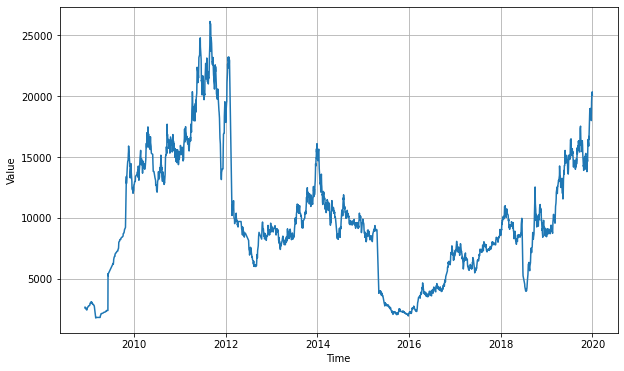

In [77]:
# Normal data

series = np.array(data.Last)
time = np.array(data.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

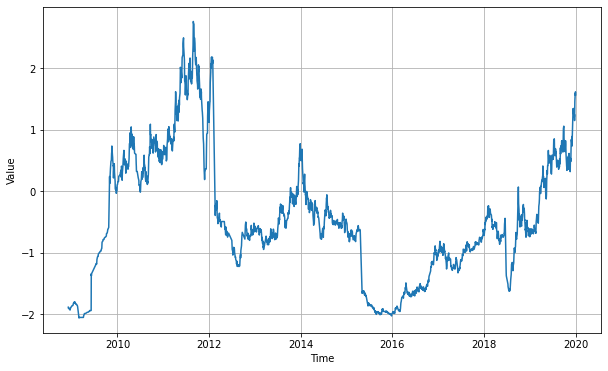

In [78]:
# Standardized Data

series = data['Last'].values.reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

series = np.array(series)
time = np.array(data.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [79]:
split_time = 2000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [80]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [81]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [82]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2000,)
Epoch 1/100
62/62 [==============================] - 8s 47ms/step - loss: 3.3210 - mae: 3.7910 - lr: 1.0000e-08
Epoch 2/100
62/62 [==============================] - 3s 46ms/step - loss: 2.4013 - mae: 2.8781 - lr: 1.1220e-08
Epoch 3/100
62/62 [==============================] - 3s 49ms/step - loss: 1.7693 - mae: 2.2333 - lr: 1.2589e-08
Epoch 4/100
62/62 [==============================] - 3s 48ms/step - loss: 1.4848 - mae: 1.9482 - lr: 1.4125e-08
Epoch 5/100
62/62 [==============================] - 3s 46ms/step - loss: 1.3070 - mae: 1.7606 - lr: 1.5849e-08
Epoch 6/100
62/62 [==============================] - 3s 44ms/step - loss: 1.1663 - mae: 1.6093 - lr: 1.7783e-08
Epoch 7/100
62/62 [==============================] - 3s 44ms/step - loss: 1.0475 - mae: 1.4802 - lr: 1.9953e-08
Epoch 8/100
62/62 [==============================] - 3s 44ms/step - loss: 0.9501 - mae: 1.3734 - lr: 2.2387e-08
Ep

(1e-08, 0.0001, 0.0, 0.2)

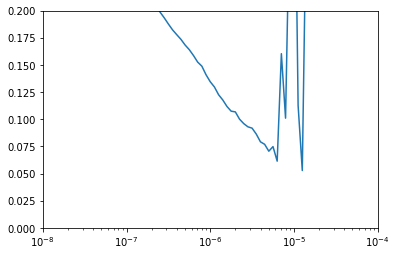

In [83]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 0.2])

In [84]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=256, kernel_size=5,
                         strides=1, padding="causal",
                         activation="relu",
                         input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=6e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
62/62 [==============================] - 9s 58ms/step - loss: 0.6157 - mae: 0.9326
Epoch 2/150
62/62 [==============================] - 4s 57ms/step - loss: 0.0784 - mae: 0.2866
Epoch 3/150
62/62 [==============================] - 4s 59ms/step - loss: 0.0560 - mae: 0.2402
Epoch 4/150
62/62 [==============================] - 4s 56ms/step - loss: 0.0485 - mae: 0.2233
Epoch 5/150
62/62 [==============================] - 4s 58ms/step - loss: 0.0400 - mae: 0.1979
Epoch 6/150
62/62 [==============================] - 4s 57ms/step - loss: 0.0360 - mae: 0.1868
Epoch 7/150
62/62 [==============================] - 4s 58ms/step - loss: 0.0281 - mae: 0.1597
Epoch 8/150
62/62 [==============================] - 4s 58ms/step - loss: 0.0219 - mae: 0.1343
Epoch 9/150
62/62 [==============================] - 4s 58ms/step - loss: 0.0218 - mae: 0.1400
Epoch 10/150
62/62 [==============================] - 4s 59ms/step - loss: 0.0181 - mae: 0.1252
Epoch 11/150
62/62 [=============================

In [85]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

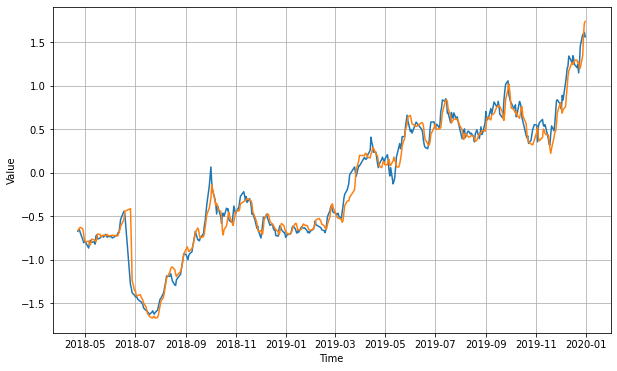

In [86]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [87]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.075315416

In [88]:
print(rnn_forecast)

# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[-0.6628057  -0.64815766 -0.6331806  -0.6267015  -0.64675695 -0.7101178
 -0.7751096  -0.7947447  -0.7852599  -0.8168053  -0.82832754 -0.7925916
 -0.76109415 -0.77071935 -0.7786335  -0.7912902  -0.75707084 -0.70354056
 -0.70717317 -0.73486763 -0.7324131  -0.720874   -0.71594846 -0.72080123
 -0.7109775  -0.7094776  -0.72135854 -0.7249188  -0.7186065  -0.7172687
 -0.72577214 -0.7139873  -0.6814898  -0.6591888  -0.61585593 -0.5366186
 -0.4417398  -0.41213688 -0.7859366  -1.2344681  -1.3510317  -1.3516519
 -1.4086866  -1.4167652  -1.4069442  -1.4004905  -1.4262434  -1.4610459
 -1.4952176  -1.5416429  -1.5910603  -1.6178776  -1.6333702  -1.6478809
 -1.6656895  -1.6666403  -1.6503576  -1.6486853  -1.6669558  -1.6631504
 -1.6308305  -1.5817759  -1.5308025  -1.4761255  -1.4325327  -1.3892105
 -1.3320118  -1.2744837  -1.211223   -1.1416737  -1.1028614  -1.0823721
 -1.0839248  -1.1115026  -1.1598415  -1.1907511  -1.1734426  -1.1343896
 -1.1014049  -1.0586809  -0.99617743 -0.9345243  -0.8738551  -